# Neuroscape playground

In [2]:
# imports
from multiprocessing import Pool
import jax
from jax import random, grad, jit, vmap, lax
import jax.numpy as jnp
import src
import importlib
from matplotlib import pyplot as plt
# black background

In [3]:
importlib.reload(src);
plt.style.use('dark_background')
plt.rcParams['font.family'] = 'Times New Roman'

In [4]:
n_steps = 100
batch_size = 16
n_samples = 100

In [7]:
reload_data = True  # flip to false after first run
args_list = ['--subject', 'subj05', '--batch_size', str(batch_size), '--n', str(n_samples), '--n_steps', str(n_steps)]
config, args = src.get_config(), src.get_args(args_list)
if reload_data:
    train_loader, val_loader, _ = src.get_loaders(args)
    next(train_loader), next(val_loader);

100%|██████████| 100/100 [00:03<00:00, 32.16it/s]


In [9]:
rng = jax.random.PRNGKey(0)
params = src.init_params(config['cnn'], rng)
metrics = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': [] }

train loss: 0.0773, train acc: 0.9719, val loss: 0.1671, val acc: 0.9625: 100%|██████████| 100/100 [00:31<00:00,  3.15it/s]


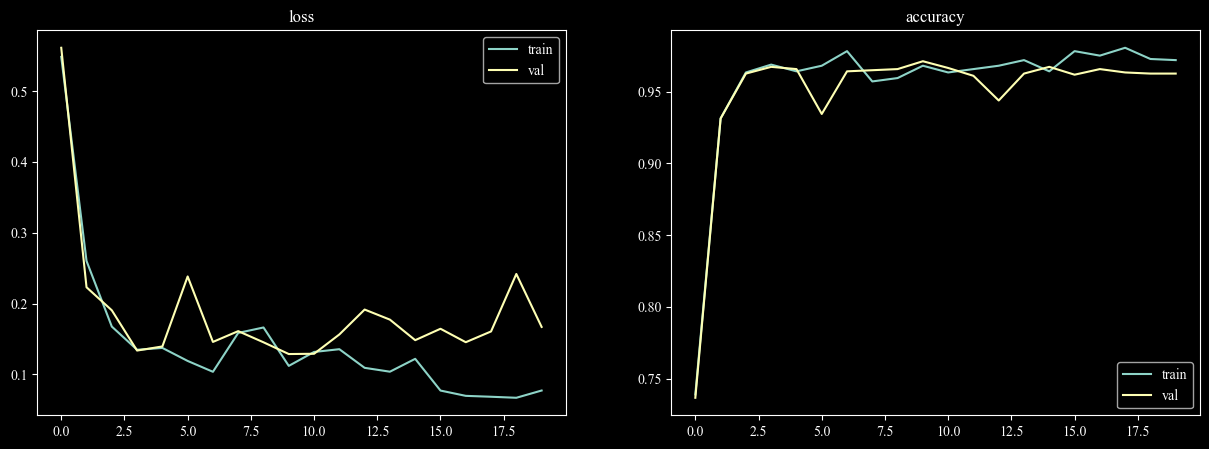

In [11]:

params, metrics = src.train(params, metrics, config, args, train_loader, val_loader)
src.plot_metrics(metrics);

In [12]:
param_sizes = [p.size for p in jax.tree_util.tree_flatten(params)[0]]
num_params = sum(param_sizes)
print(f'Number of parameters: {num_params}')

Number of parameters: 544468
